# Selecting a clean subset
In order to train a "good" feature representation, we want to first select a clean subset from the provided training set.

In [1]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
# !pip install selfclean
from selfclean import SelfClean
from selfclean.cleaner.selfclean import PretrainingType

from rsnadataset import PedsXrayRSNA2017

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
training_dataset = PedsXrayRSNA2017(
    annotations_file="/home/kesavan/Documents/Radiographs/rsna2017/train.csv",
    img_dir="/home/kesavan/Documents/Radiographs/rsna2017/train_images/",
    transform=transforms.Compose([transforms.Resize((256,256)), transforms.PILToTensor()]),
)
# plt.imshow(training_dataset[0][0][0])
# print(training_dataset[0][1].device)

In [4]:
validation_dataset = PedsXrayRSNA2017(
    annotations_file="/home/kesavan/Documents/Radiographs/rsna2017/valid.csv",
    img_dir="/home/kesavan/Documents/Radiographs/rsna2017/valid_images/",
    transform=transforms.Compose([transforms.Resize((256,256)), transforms.PILToTensor()]),
)

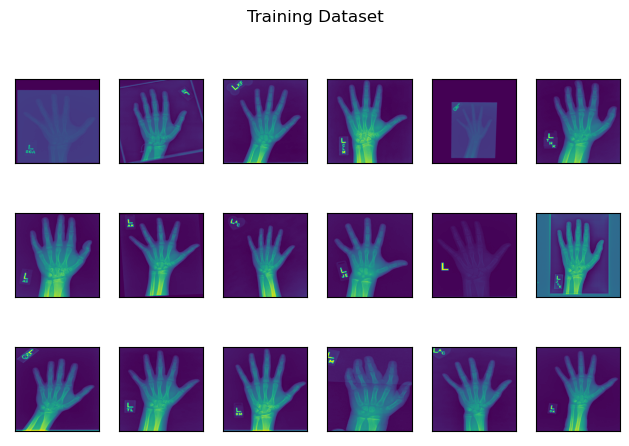

In [8]:
fig, axes = plt.subplots(3, 6)
fig.suptitle("Training Dataset")
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        index = np.random.randint(0, high=len(training_dataset))
        ax.imshow(training_dataset[index][0][0].cpu())
        ax.set_xticks([])
        ax.set_yticks([])
        index += 1
fig.tight_layout()
plt.show()

In this small sample from the training set, we already see images that are not properly cropped, rotated, and have poor brightness. These consistute examples that we want to exclude from our "hand-picked" training set.

In [6]:
slc = SelfClean(
    plot_top_N=5,
    auto_cleaning=True,
)

Creating dataset representation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-06-04 01:42:12.835 | INFO     | Fitting cleaner on representation space: (1425, 2048)


Creating distance matrix:   0%|          | 0/15 [00:00<?, ?it/s]

Processing possible near duplicates:   0%|          | 0/102 [00:00<?, ?it/s]

Processing possible irrelevant samples: 0it [00:00, ?it/s]

/home/kesavan/miniconda3/envs/torchGPU/lib/python3.9/site-packages/selfclean/cleaner/label_errors/intra_extra_distance_mixin.py:37: RuntimeWarning: invalid value encountered in multiply
  val_missing = (o_hot_diff * self.distance_matrix)[missing_same_indices]


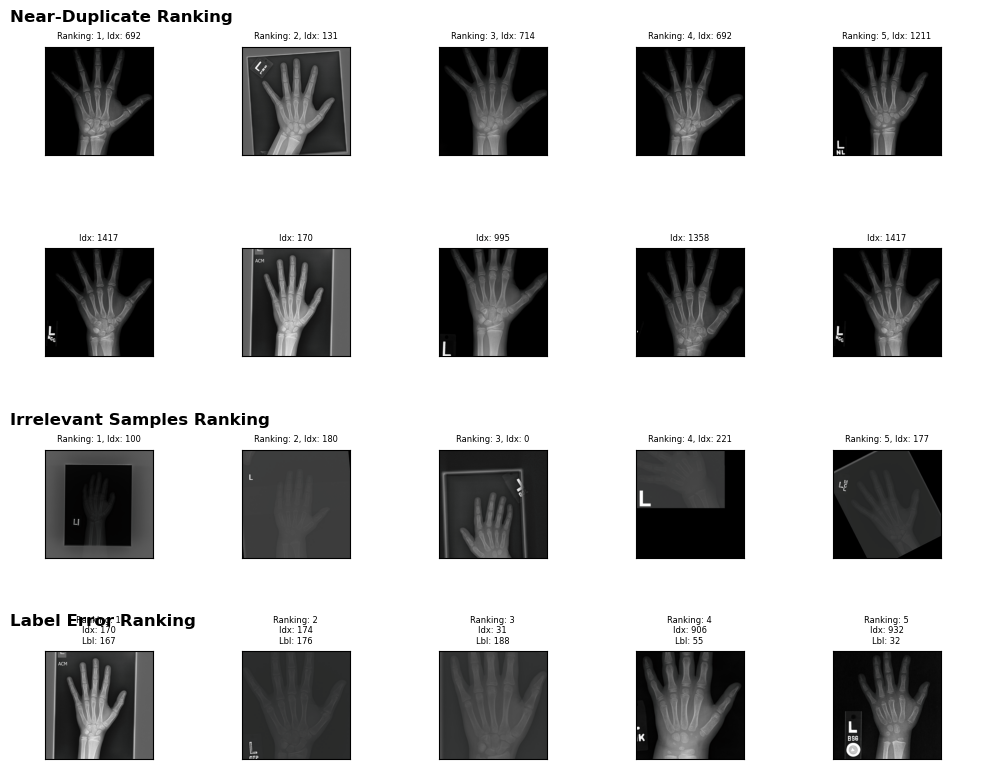

In [7]:
issues = slc.run_on_dataset(
        dataset=validation_dataset,
        epochs = 10,
        batch_size = 16,
        ssl_pre_training = True,
        save_every_n_epochs = 2,
        work_dir = "./selfclean_models",
        num_workers = os.cpu_count(),
        pretraining_type = PretrainingType.SIMCLR_IMAGENET,
    )

In [48]:
torch.save(slc.model.state_dict(), "./selfclean_models/PedsXrayRSNA2017_SIMCLR_IMAGENET_R02_model.pt")


In [74]:
torch.save(slc.cleaner.distance_matrix, "./selfclean_models/PedsXrayRSNA2017_SIMCLR_IMAGENET_R02_matrix.pt")

In [71]:
torch.save(slc.emb_space, "./selfclean_models/PedsXrayRSNA2017_SIMCLR_IMAGENET_R02_emb.pt")

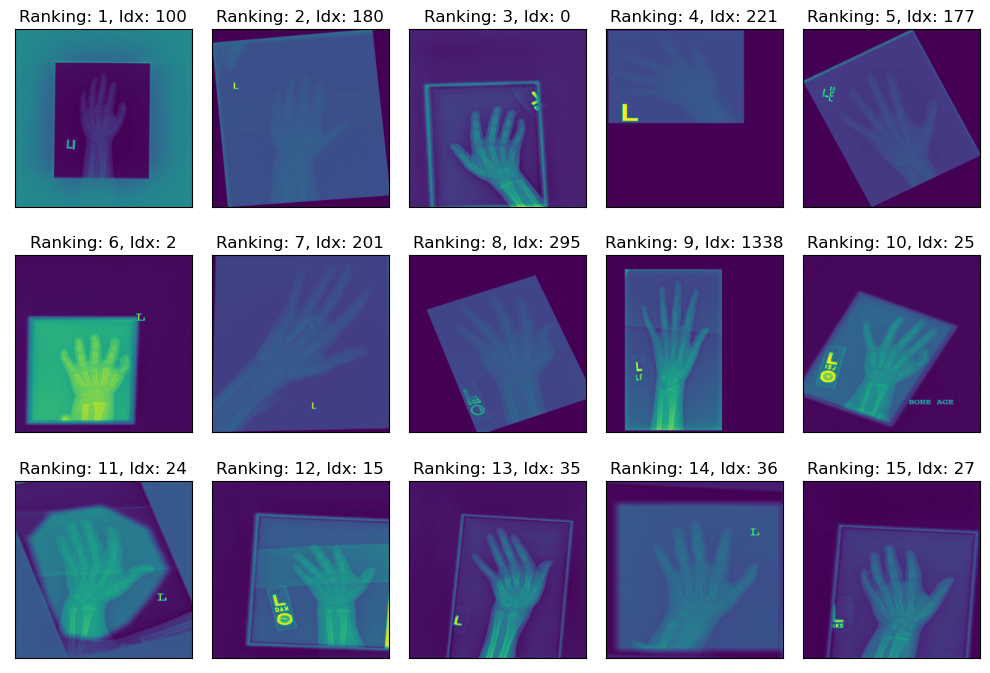

In [16]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = issues.get_issues('irrelevants')['indices'][r_index]
        ax.imshow(validation_dataset[idx][0][0].cpu().numpy())
        ax.set_title(f"Ranking: {r_index+1}, Idx: {idx}")
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

In [49]:
df_irrelevants = issues.get_issues("irrelevants", return_as_df=True)
cutoff = np.percentile(df_irrelevants["scores"], 30)
excludes = df_irrelevants[df_irrelevants["scores"] < cutoff]
print(f"30% percentile cutoff for irrelevance score is: {cutoff}")
excludes.head()

2024-06-04 02:01:03.146 | WARNING  | Returning as dataframe requires extensive memory.


30% percentile cutoff for irrelevance score is: 0.925519255379686


,indices,scores,auto_issues,label
0,100,0.809645,True,168
1,180,0.834660,False,18
2,0,0.841985,False,30
3,221,0.843719,False,15
4,177,0.855181,False,159


In [50]:
exclude_indices = excludes["indices"].tolist()
exclude_ids = list(training_dataset.img_df["id"][exclude_indices])
np.savetxt("./selfclean_models/PedsXrayRSNA2017_SIMCLR_IMAGENET_R02_valid_exclude_ids.txt", exclude_ids, fmt="%d")

#### Cleaning the training dataset using SPC rules and a feature representation derived from the validation set
What we showed above was that finetuning SimClr features on the validation set led to a feature representation that can sift out OODs under the "irrelevance" scoring scheme. Let's apply this feature representation to the training set and see if our SPC rules can achieve something similar.
Might need to clear memory for this (just run first few cells from above to get the dataset).

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
import selfclean

In [11]:
feature_model = selfclean.ssl_library.src.pkg.Embedder.load_pretrained(
    ssl=PretrainingType.SIMCLR_IMAGENET.value
)
feature_model.load_state_dict(torch.load("./selfclean_models/PedsXrayRSNA2017_SIMCLR_IMAGENET_R02_model.pt"))
feature_model.to(device)

2024-06-11 15:54:26.773 | DEBUG    | selfclean.ssl_library.src.pkg.embedder:restart_from_checkpoint:662 - => Found `convnet.` in state_dict, trying to transform.
2024-06-11 15:54:26.798 | DEBUG    | selfclean.ssl_library.src.pkg.embedder:restart_from_checkpoint:672 - => loaded 'state_dict' from checkpoint '/tmp/tmpfmj8pn3z' with msg _IncompatibleKeys(missing_keys=[], unexpected_keys=['projection.fc1.weight', 'projection.bn1.weight', 'projection.bn1.bias', 'projection.bn1.running_mean', 'projection.bn1.running_var', 'projection.bn1.num_batches_tracked', 'projection.fc2.weight', 'projection.bn2.weight', 'projection.bn2.bias', 'projection.bn2.running_mean', 'projection.bn2.running_var', 'projection.bn2.num_batches_tracked'])


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [12]:
valid_emb_space = torch.load("./selfclean_models/PedsXrayRSNA2017_SIMCLR_IMAGENET_R02_emb.pt")
print(valid_emb_space.shape)

(1425, 2048)


In [13]:
from scipy.spatial import distance
centroid = np.mean(valid_emb_space, axis=0)
valid_similarities = [1 - distance.cosine(vector, centroid) for vector in valid_emb_space]
mean = np.mean(valid_similarities)
std = np.std(valid_similarities)
sigma = 2.0
upper_limit = mean + sigma * std
lower_limit = mean - sigma * std
mean, std, upper_limit, lower_limit

(0.8085771859319586, 0.05677698198179432, 0.9221311498955472, 0.69502322196837)

In [14]:
from tqdm import tqdm
from torch.utils.data import DataLoader
dataloader = DataLoader(training_dataset, batch_size=4,
                        shuffle=False, num_workers=0)
train_similarities = []
for sample_batched in tqdm(dataloader):
    emb = feature_model(sample_batched[0].float()).squeeze().detach().cpu().numpy()
    sims = 1 - distance.cdist(emb, centroid.reshape(1,-1), 'cosine')
#     print(sims.squeeze())
    train_similarities.extend(sims.squeeze())
#     if i_batch > 5: break

100%|███████████████████████████████████████| 3153/3153 [06:59<00:00,  7.51it/s]


In [15]:
train_spc_scores = [1 if val > upper_limit or val < lower_limit else 0 for val in train_similarities]

In [16]:
class SPCChartPlotter:
    def __init__(self, mean, std, sigma_level):
        """
        Initializes the SPCChartPlotter with control limits based on mean, standard deviation, and sigma level.

        Parameters:
        - mean (float): Mean value for control limits.
        - std (float): Standard deviation for control limits.
        - sigma_level (int): Sigma level for control limits (usually 2 or 3).
        """
        self.mean = mean
        self.std = std
        self.sigma_level = sigma_level
        self.upper_control_limit = np.clip(mean + sigma_level * std, a_min=0.0, a_max=1.0)
        self.lower_control_limit = np.clip(mean - sigma_level * std, a_min=0.0, a_max=1.0)

    def plot_chart(self, day_data, day_labels, day_number):
        """
        Plots the SPC chart for a given day, highlighting control limit violations and known OOD points.

        Parameters:
        - day_data (list): Data points for the day.
        - day_labels (list): Labels indicating whether each point is out-of-distribution (OOD).
        - day_number (int): The day number for the chart title.
        """
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.scatter(range(len(day_data)), day_data, marker='o', linestyle='-', color='k', label=f'{day_number} Data')

        # Plot control limits and mean
        ax.axhline(self.upper_control_limit, color='r', linestyle='--', label='Upper Control Limit (UCL)')
        ax.axhline(self.lower_control_limit, color='g', linestyle='--', label='Lower Control Limit (LCL)')
        ax.axhline(self.mean, color='b', linestyle='-', label='Mean')

        # Highlight out-of-distribution points and control limit violations
        for i, (val, label) in enumerate(zip(day_data, day_labels)):
            if np.abs(val - self.mean) >= self.sigma_level * self.std:
                ax.plot(i, val, '*', color='grey', markersize=16, label='Auto OOD')
            if label == 'out-dist':
                ax.plot(i, val, marker='o', markersize=16, linestyle='None', color='black', mfc='none', label='Actual OOD')

        ax.set_title(f'SPC Chart for Day {day_number}')
        ax.set_xlabel('Image Sequence')
        ax.set_ylabel('Cosine Similarity')
        ax.set_ylim([0, 1])
        ax.grid(True)
        # Handle legend entries
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        plt.show()

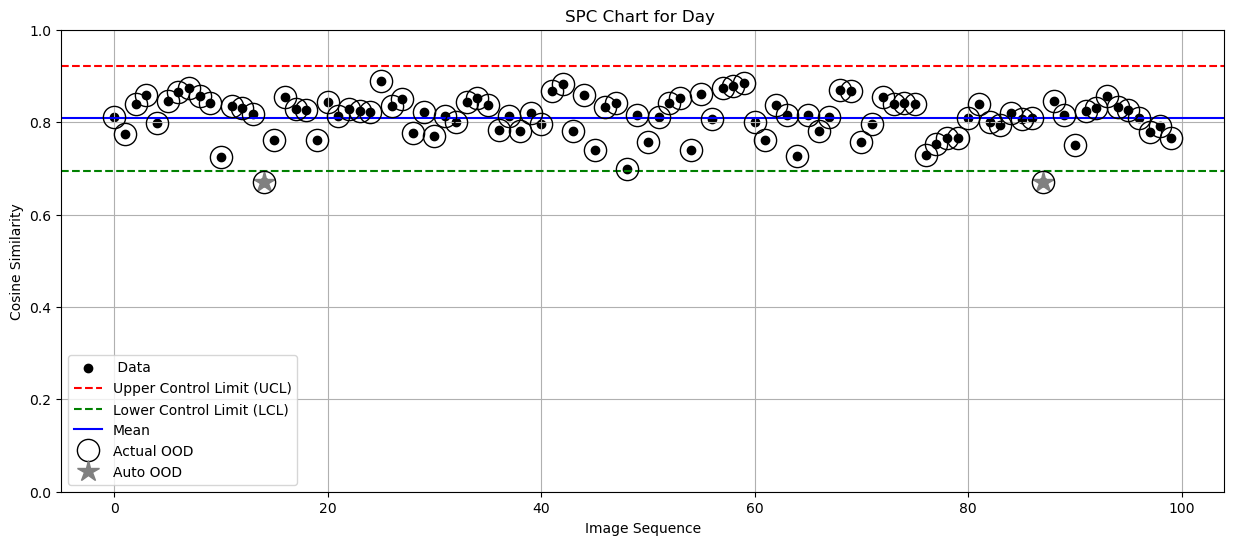

In [17]:
SPCplotter = SPCChartPlotter(mean, std, sigma)
SPCplotter.plot_chart(train_similarities[1000:1100], ["out-dist"] * 100, "")

In [18]:
np.where(train_similarities < lower_limit)

(array([ 863,  893, 1014, 1087, 1124, 1585, 1603, 2040, 2183, 2564, 2588,
        4081, 5932, 7442, 8504, 9229]),)

In [19]:
train_similarities[1124]

0.6830074498069583

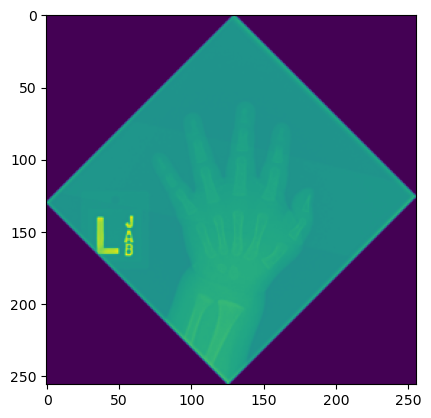

In [20]:
plt.imshow(training_dataset[1124][0].squeeze().cpu()[0])

In [21]:
np.where(np.abs(train_similarities - mean) < 1e-4)

(array([  206,  2374,  5485,  5692,  6373,  7238,  7700,  8807, 10130,
        10604, 10623, 10822]),)

In [24]:
train_similarities[5485]

0.8085763996382385

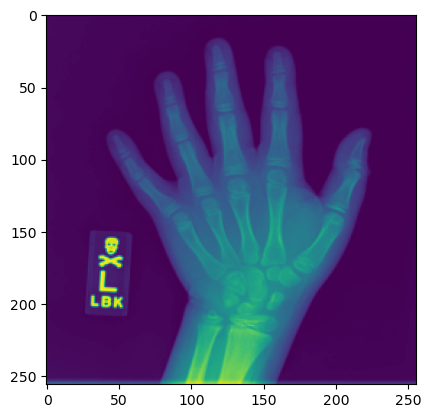

In [25]:
plt.imshow(training_dataset[5485][0].squeeze().cpu()[0])